In [1]:
import cml.data_v1 as cmldata
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Connect to Spark
CONNECTION_NAME = os.environ["CONNECTION_NAME"]   # Replace with your actual connection name
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Define database and load raw data
DBNAME = "bnk_mlops_hol_ozarate"
TABLE_NAME = "bank_marketing_ozarate"
df = spark.table(f"{DBNAME}.{TABLE_NAME}")

Setting spark.hadoop.yarn.resourcemanager.principal to ozarate


Spark Application Id:spark-9ef7749469634d36b0c4a3749493e63e


Hive Session ID = d1220c02-62e1-4002-b241-58eff0b1ebb5


In [2]:
# Define column types
numerical_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# Cast numerical columns to double
for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# 1. Basic Descriptive Stats
print(f"Dataset Size: {df.count()} rows and {len(df.columns)} columns")
df.printSchema()
df.show(5)

Dataset Size: 45211 rows and 17 columns
root
 |-- age: double (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: double (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



+----+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+----+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|58.0|  management|married| tertiary|     no| 2143.0|    yes|  no|unknown|5.0|  may|   261.0|     1.0| -1.0|     0.0| unknown| no|
|44.0|  technician| single|secondary|     no|   29.0|    yes|  no|unknown|5.0|  may|   151.0|     1.0| -1.0|     0.0| unknown| no|
|33.0|entrepreneur|married|secondary|     no|    2.0|    yes| yes|unknown|5.0|  may|    76.0|     1.0| -1.0|     0.0| unknown| no|
|47.0| blue-collar|married|  unknown|     no| 1506.0|    yes|  no|unknown|5.0|  may|    92.0|     1.0| -1.0|     0.0| unknown| no|
|33.0|     unknown| single|  unknown|     no|    1.0|     no|  no|unknown|5.0|  may

In [3]:
# Summary statistics for numerical columns
summary_df = df.select(numerical_cols).describe()
summary_df.show()

+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|summary|               age|           balance|              day|         duration|         campaign|             pdays|          previous|
+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|  count|             45211|             45211|            45211|            45211|            45211|             45211|             45211|
|   mean| 40.93621021432837|1362.2720576850766|15.80641879188693|258.1630797814691|2.763840658246887| 40.19782796222158|0.5803233726305546|
| stddev|10.618762040975405|3044.7658291685257|8.322476153044594|257.5278122651706|3.098020883279192|100.12874599059828| 2.303441044931218|
|    min|              18.0|           -8019.0|              1.0|              0.0|              1.0|              -1.0|               0.0|
|    max|           

#### Correlation Matrix

Computing Correlation Matrix...


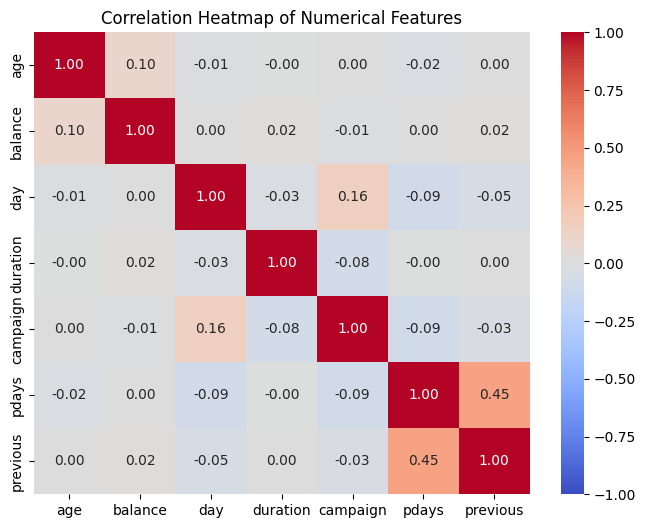

In [5]:
print("Computing Correlation Matrix...")
corr_matrix = np.zeros((len(numerical_cols), len(numerical_cols)))
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i <= j:
            corr_matrix[i, j] = df.stat.corr(col1, col2)
            corr_matrix[j, i] = corr_matrix[i, j]

corr_df = pd.DataFrame(corr_matrix, index=numerical_cols, columns=numerical_cols)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [6]:
# Correlation with target
df = df.withColumn("y_binary", when(col("y") == "yes", 1.0).otherwise(0.0))
for col_name in numerical_cols:
    corr_value = df.stat.corr(col_name, "y_binary")
    print(f"Correlation between {col_name} and y_binary: {corr_value:.3f}")

Correlation between age and y_binary: 0.025
Correlation between balance and y_binary: 0.053
Correlation between day and y_binary: -0.028
Correlation between duration and y_binary: 0.395
Correlation between campaign and y_binary: -0.073
Correlation between pdays and y_binary: 0.104
Correlation between previous and y_binary: 0.093


### Age Distribution

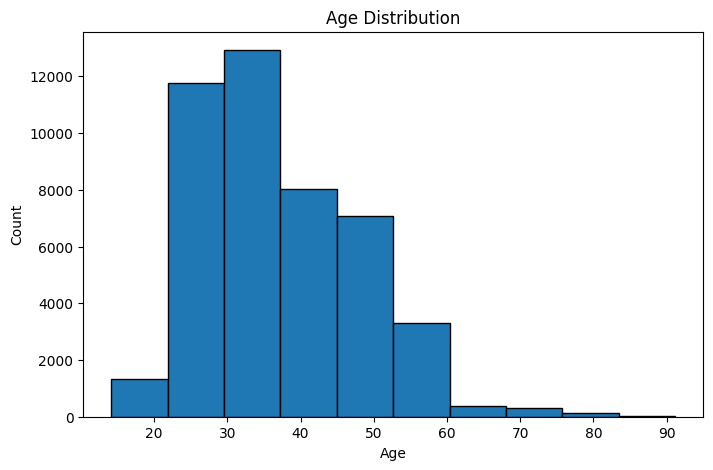

In [7]:
age_hist = df.select("age").rdd.flatMap(lambda x: x).histogram(10)
plt.figure(figsize=(8, 5))
plt.bar(age_hist[0][:-1], age_hist[1], width=(age_hist[0][1] - age_hist[0][0]), edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Job Bar Plot

/tmp/ipykernel_454/1834671564.py:3: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="job", y="count", data=job_counts, palette="viridis")


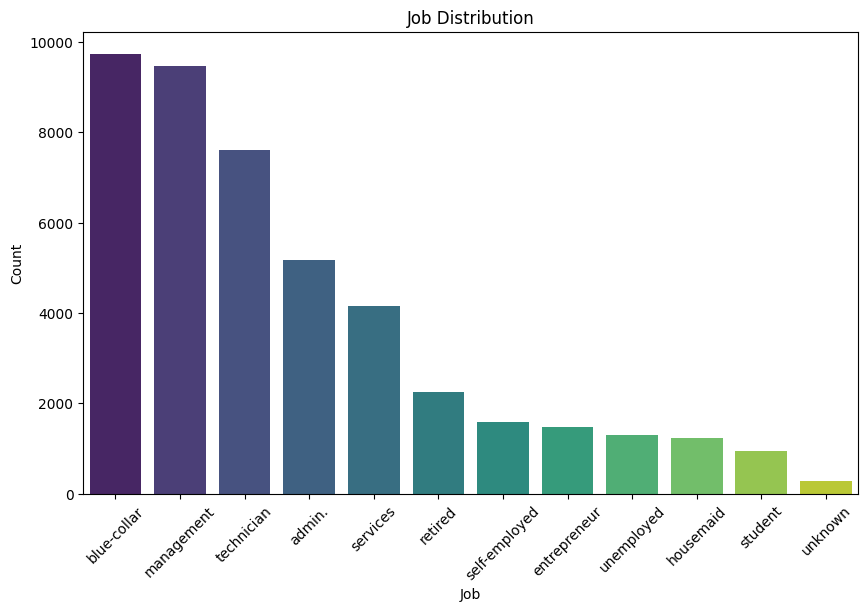

In [10]:
job_counts = df.groupBy("job").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="job", y="count", data=job_counts, palette="viridis")
plt.title("Job Distribution")
plt.xlabel("Job")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [12]:
print("\nTraining Decision Tree for Feature Importance...")
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in categorical_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

all_features = numerical_cols + [f"{col}_idx" for col in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
dt_df = assembler.transform(df_indexed)

dt = DecisionTreeClassifier(featuresCol="features", labelCol="y_binary", maxDepth=5)
dt_model = dt.fit(dt_df)

importances = dt_model.featureImportances
feature_importance_dict = {all_features[i]: importances[i] for i in range(len(all_features)) if importances[i] > 0}
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
total_importance = sum(importance for _, importance in sorted_importances)
print("\nFeature Importance Table:")
print(f"{'Feature':<20} {'Importance':<15} {'Percent Importance':<15}")
print("-" * 50)
for feature, importance in sorted_importances:
    percent_importance = (importance / total_importance) * 100 if total_importance > 0 else 0
    print(f"{feature:<20} {importance:<15.4f} {percent_importance:<15.2f}%")


Training Decision Tree for Feature Importance...

Feature Importance Table:
Feature              Importance      Percent Importance
--------------------------------------------------
duration             0.5605          56.05          %
poutcome_idx         0.2380          23.80          %
pdays                0.1007          10.07          %
month_idx            0.0435          4.35           %
day                  0.0274          2.74           %
contact_idx          0.0210          2.10           %
balance              0.0034          0.34           %
job_idx              0.0031          0.31           %
marital_idx          0.0024          0.24           %


### Select top features and save

In [13]:

top_features = [f[0] for f in sorted_importances[:10]]
df_selected = df_indexed.select(top_features + ["y"])
df_selected.show(5)
df_selected.writeTo(f"{DBNAME}.BANK_MARKETING_SELECTED_ozarate")\
    .using("iceberg").tableProperty("write.format.default", "parquet")\
    .createOrReplace()
print("Selected features saved as BANK_MARKETING_SELECTED_ozarate")

# Verify the save
print("Tables in bnk_mlops_hol_ozarate:")
spark.sql(f"SHOW TABLES IN {DBNAME}").show(truncate=False)

+--------+------------+-----+---------+---+-----------+-------+-------+-----------+---+
|duration|poutcome_idx|pdays|month_idx|day|contact_idx|balance|job_idx|marital_idx|  y|
+--------+------------+-----+---------+---+-----------+-------+-------+-----------+---+
|   261.0|         0.0| -1.0|      0.0|5.0|        1.0| 2143.0|    1.0|        0.0| no|
|   151.0|         0.0| -1.0|      0.0|5.0|        1.0|   29.0|    2.0|        1.0| no|
|    76.0|         0.0| -1.0|      0.0|5.0|        1.0|    2.0|    7.0|        0.0| no|
|    92.0|         0.0| -1.0|      0.0|5.0|        1.0| 1506.0|    0.0|        0.0| no|
|   198.0|         0.0| -1.0|      0.0|5.0|        1.0|    1.0|   11.0|        1.0| no|
+--------+------------+-----+---------+---+-----------+-------+-------+-----------+---+
only showing top 5 rows



Selected features saved as BANK_MARKETING_SELECTED_ozarate
Tables in bnk_mlops_hol_ozarate:
+---------------------+-------------------------------+-----------+
|namespace            |tableName                      |isTemporary|
+---------------------+-------------------------------+-----------+
|bnk_mlops_hol_ozarate|bank_marketing_ozarate         |false      |
|bnk_mlops_hol_ozarate|bank_marketing_selected_ozarate|false      |
+---------------------+-------------------------------+-----------+

